# Machine Learning: Project 1

In [126]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
import joblib
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LinearRegression, LogisticRegression
# from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.svm import SVR, LinearSVR, LinearSVC
from sklearn.base import clone
import pickle
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, f1_score, classification_report

In [35]:
# Column Selector based on dtype (from lecture)
class Selector(BaseEstimator, TransformerMixin):
    """
    Selcects the features (numerical, categorical or all)
    """

    def __init__(self, select):
        """
        select has to be "num features", "cat features" or "all features"
        """

        if select not in ["num features", "cat features", "all features"]:
            raise TypeError("for select only num features, cat features or all features")

        self.select = select
        self.num_attr = None
        self.cat_attr = None

    def fit(self, x: pd.DataFrame, _y=None):
        """fits the parameter"""

        if not isinstance(x, pd.DataFrame):
            raise TypeError("Selector needs Pandas Dataframe!")

        self.num_attr = list(x.select_dtypes(include=[np.number]).columns)
        self.cat_attr = list(x.select_dtypes(exclude=[np.number]).columns)

        return self

    def transform(self, x: pd.DataFrame, _y=None):
        """does the transformation"""

        if not isinstance(x, pd.DataFrame):
            raise TypeError("Selector needs Pandas Dataframe!")

        if self.select == "num features":
            x_new = x[self.num_attr].copy()
        elif self.select == "cat features":
            x_new = x[self.cat_attr].copy()
        elif self.select == "all features":
            x_new = x[self.num_attr + self.cat_attr].copy()
        else:
            raise TypeError("for select only num features, cat features or all features")

        return x_new

    def get_feature_names_out(self):
        """this method is needed, otherwise we cannot use set_ouput"""
        pass

In [36]:
df = pd.read_csv('project_1_train.csv')

In [37]:
df.head()

,NR,Gender,Age,AgeDecade,AgeMonths,Race1,Race3,Education,MaritalStatus,HHIncome,...,RegularMarij,AgeRegMarij,HardDrugs,SexEver,SexAge,SexNumPartnLife,SexNumPartYear,SameSex,SexOrientation,PregnantNow
0,9217,male,44,40-49,NaN,White,White,High School,Divorced,25000-34999,...,No,NaN,Yes,Yes,17.0,20.0,1.0,No,Heterosexual,NaN
1,7325,male,50,50-59,NaN,White,White,College Grad,NeverMarried,NaN,...,No,NaN,No,Yes,24.0,1.0,0.0,Yes,Homosexual,NaN
2,919,female,59,50-59,718.0,Black,NaN,High School,Widowed,45000-54999,...,No,NaN,No,Yes,17.0,3.0,1.0,No,Heterosexual,NaN
3,5903,female,40,40-49,NaN,White,White,College Grad,Divorced,0-4999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
4,2808,female,13,10-19,166.0,Hispanic,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 71 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   NR                8000 non-null   int64  
 1   Gender            8000 non-null   object 
 2   Age               8000 non-null   int64  
 3   AgeDecade         7740 non-null   object 
 4   AgeMonths         3975 non-null   float64
 5   Race1             8000 non-null   object 
 6   Race3             3994 non-null   object 
 7   Education         5800 non-null   object 
 8   MaritalStatus     5806 non-null   object 
 9   HHIncome          7359 non-null   object 
 10  HHIncomeMid       7359 non-null   float64
 11  Poverty           7423 non-null   float64
 12  HomeRooms         7943 non-null   float64
 13  HomeOwn           7948 non-null   object 
 14  Work              6241 non-null   object 
 15  Weight            7936 non-null   float64
 16  Height            7727 non-null   float64


In [39]:
df.describe()

,NR,Age,AgeMonths,HHIncomeMid,Poverty,HomeRooms,Weight,Height,BMI,Pulse,...,TVHrsDayChild,CompHrsDayChild,AlcoholDay,AlcoholYear,SmokeAge,AgeFirstMarij,AgeRegMarij,SexAge,SexNumPartnLife,SexNumPartYear
count,8000.000000,8000.000000,3975.000000,7359.000000,7423.000000,7943.000000,7936.000000,7727.000000,7716.000000,6862.000000,...,507.000000,507.000000,3936.000000,4734.000000,2478.000000,2339.000000,1086.000000,4464.000000,4600.000000,3969.000000
mean,5012.554250,36.667500,421.240000,57291.411877,2.807810,6.249024,71.160622,161.934088,26.673793,73.484115,...,1.950690,2.230769,2.931911,75.257710,17.761905,17.050876,17.753223,17.433468,14.243261,1.356513
std,2887.242281,22.265459,257.011081,33114.586076,1.684218,2.278170,29.010355,20.154350,7.346642,12.090593,...,1.418238,2.560725,3.187721,102.078749,5.170704,3.944924,4.907613,3.695085,47.260997,2.709867
min,1.000000,0.000000,0.000000,2500.000000,0.000000,1.000000,2.800000,83.600000,12.890000,40.000000,...,0.000000,0.000000,1.000000,0.000000,6.000000,1.000000,5.000000,9.000000,0.000000,0.000000
25%,2528.750000,18.000000,204.000000,30000.000000,1.240000,5.000000,56.300000,157.100000,21.600000,64.000000,...,1.000000,0.000000,1.000000,3.000000,15.000000,15.000000,15.000000,15.000000,2.000000,1.000000
50%,4994.000000,36.000000,420.000000,50000.000000,2.720000,6.000000,72.750000,166.100000,26.000000,72.000000,...,2.000000,1.000000,2.000000,24.000000,17.000000,16.000000,17.000000,17.000000,5.000000,1.000000
75%,7504.250000,54.000000,619.000000,87500.000000,4.760000,8.000000,89.200000,174.500000,30.930000,82.000000,...,3.000000,6.000000,3.000000,104.000000,19.000000,19.000000,19.000000,19.000000,12.000000,1.000000
max,10000.000000,80.000000,959.000000,100000.000000,5.000000,13.000000,230.700000,200.400000,81.250000,134.000000,...,6.000000,6.000000,82.000000,364.000000,72.000000,48.000000,52.000000,50.000000,1000.000000,69.000000


In [40]:
df['DirectChol']

0       1.11
1       1.01
2       1.63
3       1.47
4       1.19
        ... 
7995    1.34
7996    1.09
7997    1.84
7998    1.50
7999    1.27
Name: DirectChol, Length: 8000, dtype: float64

In [41]:
# Drop columns with more than 1500 nas
max_number_of_nas = 1500
newdf = df.loc[:, (df.isnull().sum(axis=0) <= max_number_of_nas)]

newdf.dropna(inplace=True)
newdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4697 entries, 0 to 7996
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   NR           4697 non-null   int64  
 1   Gender       4697 non-null   object 
 2   Age          4697 non-null   int64  
 3   AgeDecade    4697 non-null   object 
 4   Race1        4697 non-null   object 
 5   HHIncome     4697 non-null   object 
 6   HHIncomeMid  4697 non-null   float64
 7   Poverty      4697 non-null   float64
 8   HomeRooms    4697 non-null   float64
 9   HomeOwn      4697 non-null   object 
 10  Weight       4697 non-null   float64
 11  Height       4697 non-null   float64
 12  BMI          4697 non-null   float64
 13  BMI_WHO      4697 non-null   object 
 14  Pulse        4697 non-null   float64
 15  BPSysAve     4697 non-null   float64
 16  BPDiaAve     4697 non-null   float64
 17  BPSys1       4697 non-null   float64
 18  BPDia1       4697 non-null   float64
 19  BPSys2     

C:\Users\Admin\AppData\Local\Temp\ipykernel_10152\2557067911.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newdf.dropna(inplace=True)


## Regression

In [42]:
# Prep for regression
y_reg = newdf['DirectChol']
x_reg = newdf.drop(columns=['DirectChol'])

X_train, X_test, y_train, y_test = train_test_split(x_reg, y_reg, test_size=0.2, random_state=123)

In [43]:
scores = {}  # containing scores and pipeline info

# Score Helper Function
def display_scores(model_score):
    """print the list of scores, the mean and the standard deviation"""
    print("SCORES OF CROSS VALIDATION:")
    print(np.round(model_score, decimals=1))
    print("MEAN SCORE: %0.1f" % model_score.mean())
    print("STD SCORE: %0.1f\n" % model_score.std())


### Linear Regression

In [49]:
def lin_reg(x, y):
    """define model 1"""
    start = time.time()

    # numeric feature preparation
    pipeline_num = Pipeline([
        ("selector", Selector("num features")),  # select numeric attributes
        ("imputer", SimpleImputer(strategy="median")),  # missing values are replaced by column median of train_set toDo better to drop with our dataset?
        ("scaler", StandardScaler()),  # scale to mean 0 and std 1 toDo: Maybe min_max_scaler?
    ])

    # categorical feature preparation toDo: is this necessary?
    pipeline_cat = Pipeline([
        ("selector", Selector("cat features")),  # select categorical attributes
        ("one_hot_encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop="first", dtype=bool)),  # one-hot-encoding
    ])

    # combine numeric and categorical feature preparation
    pipeline_full = FeatureUnion(transformer_list=[
        ("pipeline_num", pipeline_num),
        ("pipeline_cat", pipeline_cat),
    ])

    # set output to pandas, so we can use pandas tools again (e.g. for feature_names_in_)
    pipeline_full.set_output(transform="pandas")

    model = Pipeline([
        ("pipeline_full", pipeline_full),
        ("regressor", LinearRegression()),
    ])

    model.fit(x, y)

    model_predictions = model.predict(x)

    # attention: it is not allowed to use a fitted model (like model) in cross_val_predict because information gets through
    # unfitted model (clone(model)) is used for cross validation

    model_new = clone(model)
    model_scores = cross_val_score(model_new, x, y, scoring="neg_mean_squared_error", cv=3, n_jobs=-1)

    end = time.time()
    model_time = end - start

    # store model
    with open("output_reg/lin_reg.pkl", "wb") as file:
        pickle.dump(model, file)
    joblib.dump(model_predictions, filename="output_reg/lin_reg_predictions.pkl")
    joblib.dump(model_scores, filename="output_reg/lin_reg_scores.pkl")
    joblib.dump(model_time, filename="output_reg/lin_reg_time.pkl")

In [50]:
lin_reg(X_train, y_train)

In [51]:
model_1 = joblib.load("output_reg/lin_reg.pkl")
model_1_predictions = joblib.load("output_reg/lin_reg_predictions.pkl")
model_1_scores = joblib.load("output_reg/lin_reg_scores.pkl")
model_1_time = joblib.load("output_reg/lin_reg_time.pkl")

print("TIME: ", round(model_1_time, 2), " sec\n")

print("RMSE: %0.1f\n" % np.sqrt(mean_squared_error(y_train, model_1_predictions)))

scores["model_1"] = [np.sqrt(-model_1_scores).mean(), model_1, "lin_reg"]
print("VALUE FOR COMPARISON: CV RMSE", round(scores["model_1"][0], 2), "\n")
display_scores(np.sqrt(-model_1_scores))

print("USED FEATURES:", model_1["regressor"].n_features_in_)

model_1_feature_importances = pd.DataFrame(
    {
        "name": model_1["regressor"].feature_names_in_,
        "value": model_1["regressor"].coef_.flatten(),
        "abs_value": np.abs(model_1["regressor"].coef_).flatten()
    }).sort_values(by="abs_value")

print("FEATURE VALUE IMPORTANCE:")
print("LOWEST ABS SCORE:")
print(round(model_1_feature_importances.head(6)[["name", "value"]], 2), "\n")
print("HIGHEST ABS SCORE:")
print(round(model_1_feature_importances.tail(6)[["name", "value"]], 2), "\n")

TIME:  2.97  sec

RMSE: 0.3

VALUE FOR COMPARISON: CV RMSE 0.34 

SCORES OF CROSS VALIDATION:
[0.3 0.3 0.4]
MEAN SCORE: 0.3
STD SCORE: 0.0

USED FEATURES: 48
FEATURE VALUE IMPORTANCE:
LOWEST ABS SCORE:
           name  value
17    UrineVol1   0.00
0            NR  -0.00
11       BPSys1  -0.01
12       BPDia1   0.01
8         Pulse  -0.01
41  HomeOwn_Own  -0.01 

HIGHEST ABS SCORE:
                    name         value
39  HHIncome_75000-99999  5.533022e+10
40   HHIncome_more 99999  6.346701e+10
10              BPDiaAve  9.466151e+10
15                BPSys3 -1.110090e+12
13                BPSys2 -1.126322e+12
9               BPSysAve  2.205099e+12 



In [52]:
def lin_reg_poly(x, y):
    """define model 2"""
    start = time.time()

    # numeric feature preparation
    pipeline_num = Pipeline([
        ("selector", Selector("num features")),  # select numeric attributes
        ("imputer", SimpleImputer(strategy="median")),  # missing values are replaced by column median of train_set toDo better to drop with our dataset?
        ("poly", PolynomialFeatures(degree=2)),  # add polynomial features
        ("scaler", StandardScaler()),  # scale to mean 0 and std 1 toDo: Maybe min_max_scaler?
    ])

    # categorical feature preparation toDo: is this necessary?
    pipeline_cat = Pipeline([
        ("selector", Selector("cat features")),  # select categorical attributes
        ("one_hot_encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop="first", dtype=bool)),  # one-hot-encoding
    ])

    # combine numeric and categorical feature preparation
    pipeline_full = FeatureUnion(transformer_list=[
        ("pipeline_num", pipeline_num),
        ("pipeline_cat", pipeline_cat),
    ])

    # set output to pandas, so we can use pandas tools again (e.g. for feature_names_in_)
    pipeline_full.set_output(transform="pandas")

    model = Pipeline([
        ("pipeline_full", pipeline_full),
        ("regressor", LinearRegression()),
    ])

    model.fit(x, y)

    model_predictions = model.predict(x)

    # attention: it is not allowed to use a fitted model (like model) in cross_val_predict because information gets through
    # unfitted model (clone(model)) is used for cross validation

    model_new = clone(model)
    model_scores = cross_val_score(model_new, x, y, scoring="neg_mean_squared_error", cv=3, n_jobs=-1)

    end = time.time()
    model_time = end - start

    # store model
    with open("output_reg/lin_reg_poly.pkl", "wb") as file:
        pickle.dump(model, file)
    joblib.dump(model_predictions, filename="output_reg/lin_reg_poly_predictions.pkl")
    joblib.dump(model_scores, filename="output_reg/lin_reg_poly_scores.pkl")
    joblib.dump(model_time, filename="output_reg/lin_reg_poly_time.pkl")

In [53]:
lin_reg_poly(X_train, y_train)

In [54]:
model_2 = joblib.load("output_reg/lin_reg_poly.pkl")
model_2_predictions = joblib.load("output_reg/lin_reg_poly_predictions.pkl")
model_2_scores = joblib.load("output_reg/lin_reg_poly_scores.pkl")
model_2_time = joblib.load("output_reg/lin_reg_poly_time.pkl")

print("TIME: ", round(model_2_time, 2), " sec\n")

print("RMSE: %0.1f\n" % np.sqrt(mean_squared_error(y_train, model_2_predictions)))

scores["model_2"] = [np.sqrt(-model_2_scores).mean(), model_2, "lin_reg_poly"]
print("VALUE FOR COMPARISON: CV RMSE", round(scores["model_2"][0], 2), "\n")
display_scores(np.sqrt(-model_2_scores))

print("USED FEATURES:", model_2["regressor"].n_features_in_)

model_2_feature_importances = pd.DataFrame(
    {
        "name": model_2["regressor"].feature_names_in_,
        "value": model_2["regressor"].coef_.flatten(),
        "abs_value": np.abs(model_2["regressor"].coef_).flatten()
    }).sort_values(by="abs_value")

print("FEATURE VALUE IMPORTANCE:")
print("LOWEST ABS SCORE:")
print(round(model_2_feature_importances.head(6)[["name", "value"]], 2), "\n")
print("HIGHEST ABS SCORE:")
print(round(model_2_feature_importances.tail(6)[["name", "value"]], 2), "\n")

TIME:  0.91  sec

RMSE: 0.3

VALUE FOR COMPARISON: CV RMSE 0.35 

SCORES OF CROSS VALIDATION:
[0.3 0.3 0.4]
MEAN SCORE: 0.3
STD SCORE: 0.0

USED FEATURES: 239
FEATURE VALUE IMPORTANCE:
LOWEST ABS SCORE:
                     name  value
104  HomeRooms UrineFlow1  -0.00
209          UrineFlow1^2   0.00
88      Poverty UrineVol1  -0.00
21                 NR Age   0.01
55          Age UrineVol1  -0.01
133             BMI Pulse   0.01 

HIGHEST ABS SCORE:
                   name         value
95   HomeRooms BPSysAve -5.562247e+10
192       BPSys2 BPDia3  5.590543e+10
10             BPSysAve -6.831852e+10
163  BPSysAve UrineVol1  8.523152e+10
162     BPSysAve BPDia3 -9.677565e+10
165          BPDiaAve^2  9.745938e+10 



### Decision Tree

In [55]:
def decision_tree_reg(x, y):
    """define model 3"""
    start = time.time()

    # numeric feature preparation
    pipeline_num = Pipeline([
        ("selector", Selector("num features")),
        ("imputer", SimpleImputer(strategy="median")),  # missing values are replaced by column median of train_set
    ])

    # categorical feature preparation
    pipeline_cat = Pipeline([
        ("selector", Selector("cat features")),  # select categorical attributes
        ("one_hot_encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop="first", dtype=bool)),  # one-hot-encoding
    ])

    # combine numeric and categorical feature preparation
    pipeline_full = FeatureUnion(transformer_list=[
        ("pipeline_num", pipeline_num),
        ("pipeline_cat", pipeline_cat),
    ])

    # set output to pandas, so we can use pandas tools again (e.g. for feature_names_in_)
    pipeline_full.set_output(transform="pandas")

    # define full pipeline
    base_model = Pipeline([
        ("pipeline_full", pipeline_full),
        ("regressor", DecisionTreeRegressor(random_state=123)),
    ])

    # possible fine-tuned parameters
    model_param = [
        {
            "regressor__max_depth": [8],
            "regressor__min_samples_leaf": [0.0009],  # [0.0008, 0.0009, 0.001],
        }
    ]

    model_gs = GridSearchCV(base_model, model_param, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1)

    model_gs.fit(x, y)

    model = model_gs.best_estimator_

    model_best_params = model_gs.best_params_

    model_predictions = model.predict(x)

    # attention: it is not allowed to use a fitted model (like model) in cross_val_predict because information gets through
    # unfitted model (clone(model)) is used for cross validation

    model_new = clone(model)
    model_scores = cross_val_score(model_new, x, y, scoring="neg_mean_squared_error", cv=3, n_jobs=-1)

    end = time.time()
    model_time = end - start

    # store model
    with open("output_reg/decision_tree.pkl", "wb") as file:
        pickle.dump(model, file)

    # use the following to store the best params of grid search
    with open("output_reg/decision_tree_best_params.pkl", "wb") as ff:
        pickle.dump(model_best_params, ff)

    joblib.dump(model_predictions, filename="output_reg/decision_tree_predictions.pkl")
    joblib.dump(model_scores, filename="output_reg/decision_tree_scores.pkl")
    joblib.dump(model_time, filename="output_reg/decision_tree_time.pkl")

In [56]:
decision_tree_reg(X_train, y_train)

In [57]:
model_3 = joblib.load("output_reg/decision_tree.pkl")

with open("output_reg/decision_tree_best_params.pkl", 'rb') as f:
    model_3_best_params = pickle.load(f)

model_3_predictions = joblib.load("output_reg/decision_tree_predictions.pkl")
model_3_scores = joblib.load("output_reg/decision_tree_scores.pkl")
model_3_time = joblib.load("output_reg/decision_tree_time.pkl")

print("TIME: ", round(model_3_time, 2), " sec\n")

print("RMSE: %0.1f\n" % np.sqrt(mean_squared_error(y_train, model_3_predictions)))

scores["model_3"] = [np.sqrt(-model_3_scores).mean(), model_3, "decision_tree"]
print("VALUE FOR COMPARISON: CV RMSE", round(scores["model_3"][0], 2), "\n")
display_scores(np.sqrt(-model_3_scores))

print("USED FEATURES: ", model_3["regressor"].n_features_in_)

model_3_feature_importances = pd.DataFrame(
    {
        "name": model_3["regressor"].feature_names_in_,
        "value": model_3["regressor"].feature_importances_,
        "abs_value": np.abs(model_3["regressor"].feature_importances_)
    }).sort_values(by="abs_value")

print("FEATURE VALUE IMPORTANCE:")
print("LOWEST ABS SCORE:")
print(round(model_3_feature_importances.head(6)[["name", "value"]], 2), "\n")
print("HIGHEST ABS SCORE:")
print(round(model_3_feature_importances.tail(6)[["name", "value"]], 2), "\n")

print("OPTIMAL PARAMETERS:")
for param, value in model_3_best_params.items():
    print(param, ": ", value, sep="")
print("\n")


TIME:  0.72  sec

RMSE: 0.3

VALUE FOR COMPARISON: CV RMSE 0.38 

SCORES OF CROSS VALIDATION:
[0.4 0.4 0.4]
MEAN SCORE: 0.4
STD SCORE: 0.0

USED FEATURES:  48
FEATURE VALUE IMPORTANCE:
LOWEST ABS SCORE:
                    name  value
23      AgeDecade_ 50-59    0.0
32  HHIncome_15000-19999    0.0
31  HHIncome_10000-14999    0.0
28           Race1_Other    0.0
27         Race1_Mexican    0.0
26        Race1_Hispanic    0.0 

HIGHEST ABS SCORE:
           name  value
6        Height   0.04
18   UrineFlow1   0.05
19  Gender_male   0.06
7           BMI   0.08
1           Age   0.10
5        Weight   0.31 

OPTIMAL PARAMETERS:
regressor__max_depth: 8
regressor__min_samples_leaf: 0.0009




### Random Forest

In [58]:
def random_forest_reg(x, y):
    """Random Forest Regression."""
    start = time.time()

    # Numeric feature preparation
    pipeline_num = Pipeline([
        ("selector", Selector("num features")),
        ("imputer", SimpleImputer(strategy="median")),
    ])

    # Categorical feature preparation
    pipeline_cat = Pipeline([
        ("selector", Selector("cat features")),
        ("one_hot_encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop="first", dtype=bool)),
    ])

    # Combine numeric and categorical feature preparation
    pipeline_full = FeatureUnion(transformer_list=[
        ("pipeline_num", pipeline_num),
        ("pipeline_cat", pipeline_cat),
    ])

    # Set output to pandas
    pipeline_full.set_output(transform="pandas")

    # Define full pipeline
    base_model = Pipeline([
        ("pipeline_full", pipeline_full),
        ("regressor", RandomForestRegressor(random_state=123)),
    ])

    # Possible fine-tuned parameters
    model_param = [
        {
            "regressor__n_estimators": [100],  # Example: [100, 200]
            "regressor__max_depth": [None],  # Example: [None, 10, 20]
            "regressor__min_samples_leaf": [1],  # Example: [1, 2, 4]
        }
    ]

    model_gs = GridSearchCV(base_model, model_param, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1)
    model_gs.fit(x, y)

    model = model_gs.best_estimator_
    model_best_params = model_gs.best_params_

    model_predictions = model.predict(x)

    model_new = clone(model)
    model_scores = cross_val_score(model_new, x, y, scoring="neg_mean_squared_error", cv=3, n_jobs=-1)

    end = time.time()
    model_time = end - start

    # Store model and results
    with open("output_reg/random_forest.pkl", "wb") as file:
        pickle.dump(model, file)

    with open("output_reg/random_forest_best_params.pkl", "wb") as ff:
        pickle.dump(model_best_params, ff)

    joblib.dump(model_predictions, filename="output_reg/random_forest_predictions.pkl")
    joblib.dump(model_scores, filename="output_reg/random_forest_scores.pkl")
    joblib.dump(model_time, filename="output_reg/random_forest_time.pkl")


In [59]:
random_forest_reg(X_train, y_train)

In [60]:
model_4 = joblib.load("output_reg/random_forest.pkl")

with open("output_reg/random_forest_best_params.pkl", 'rb') as f:
    model_4_best_params = pickle.load(f)

model_4_predictions = joblib.load("output_reg/random_forest_predictions.pkl")
model_4_scores = joblib.load("output_reg/random_forest_scores.pkl")
model_4_time = joblib.load("output_reg/random_forest_time.pkl")

print("TIME: ", round(model_4_time, 2), " sec\n")

print("RMSE: %0.1f\n" % np.sqrt(mean_squared_error(y_train, model_4_predictions)))

scores["model_4"] = [np.sqrt(-model_4_scores).mean(), model_4, "random_forest"]
print("VALUE FOR COMPARISON: CV RMSE", round(scores["model_4"][0], 2), "\n")
display_scores(np.sqrt(-model_4_scores))

print("USED FEATURES: ", model_4["regressor"].n_features_in_)

model_4_feature_importances = pd.DataFrame(
    {
        "name": model_4["regressor"].feature_names_in_,
        "value": model_4["regressor"].feature_importances_,
        "abs_value": np.abs(model_4["regressor"].feature_importances_)
    }).sort_values(by="abs_value")

print("FEATURE VALUE IMPORTANCE:")
print("LOWEST ABS SCORE:")
print(round(model_4_feature_importances.head(6)[["name", "value"]], 2), "\n")
print("HIGHEST ABS SCORE:")
print(round(model_4_feature_importances.tail(6)[["name", "value"]], 2), "\n")

print("OPTIMAL PARAMETERS:")
for param, value in model_4_best_params.items():
    print(param, ": ", value, sep="")
print("\n")


TIME:  83.04  sec

RMSE: 0.1

VALUE FOR COMPARISON: CV RMSE 0.3 

SCORES OF CROSS VALIDATION:
[0.3 0.3 0.3]
MEAN SCORE: 0.3
STD SCORE: 0.0

USED FEATURES:  48
FEATURE VALUE IMPORTANCE:
LOWEST ABS SCORE:
                    name  value
30   HHIncome_ 5000-9999    0.0
32  HHIncome_15000-19999    0.0
45     BMI_WHO_30.0_plus    0.0
25        AgeDecade_ 70+    0.0
44  BMI_WHO_25.0_to_29.9    0.0
26        Race1_Hispanic    0.0 

HIGHEST ABS SCORE:
          name  value
6       Height   0.05
0           NR   0.05
18  UrineFlow1   0.05
1          Age   0.08
7          BMI   0.09
5       Weight   0.18 

OPTIMAL PARAMETERS:
regressor__max_depth: None
regressor__min_samples_leaf: 1
regressor__n_estimators: 100




### Support Vector Machine

In [61]:
def svr_reg(x, y):
    """Support Vector Regression."""
    start = time.time()

    # Numeric feature preparation
    pipeline_num = Pipeline([
        ("selector", Selector("num features")),
        ("imputer", SimpleImputer(strategy="median")),
    ])

    # Categorical feature preparation
    pipeline_cat = Pipeline([
        ("selector", Selector("cat features")),
        ("one_hot_encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop="first", dtype=bool)),
    ])

    # Combine numeric and categorical feature preparation
    pipeline_full = FeatureUnion(transformer_list=[
        ("pipeline_num", pipeline_num),
        ("pipeline_cat", pipeline_cat),
    ])

    # Set output to pandas
    pipeline_full.set_output(transform="pandas")

    # Define full pipeline
    base_model = Pipeline([
        ("pipeline_full", pipeline_full),
        ("regressor", SVR()),
    ])

    # Possible fine-tuned parameters
    model_param = [
        {
            "regressor__C": [1, 10, 100],  # Regularization parameter
            "regressor__kernel": ['rbf'],  # Specifies the kernel type to be used in the algorithm
        }
    ]

    model_gs = GridSearchCV(base_model, model_param, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1)
    model_gs.fit(x, y)

    model = model_gs.best_estimator_
    model_best_params = model_gs.best_params_

    model_predictions = model.predict(x)

    model_new = clone(model)
    model_scores = cross_val_score(model_new, x, y, scoring="neg_mean_squared_error", cv=3, n_jobs=-1)

    end = time.time()
    model_time = end - start

    # Store model and results
    with open("output_reg/svr.pkl", "wb") as file:
        pickle.dump(model, file)

    with open("output_reg/svr_best_params.pkl", "wb") as ff:
        pickle.dump(model_best_params, ff)

    joblib.dump(model_predictions, filename="output_reg/svr_predictions.pkl")
    joblib.dump(model_scores, filename="output_reg/svr_scores.pkl")
    joblib.dump(model_time, filename="output_reg/svr_time.pkl")
    

In [62]:
svr_reg(X_train, y_train)

In [63]:
model_5 = joblib.load("output_reg/svr.pkl")

with open("output_reg/svr_best_params.pkl", 'rb') as f:
    model_5_best_params = pickle.load(f)

model_5_predictions = joblib.load("output_reg/svr_predictions.pkl")
model_5_scores = joblib.load("output_reg/svr_scores.pkl")
model_5_time = joblib.load("output_reg/svr_time.pkl")

print("TIME: ", round(model_5_time, 2), " sec\n")

print("RMSE: %0.1f\n" % np.sqrt(mean_squared_error(y_train, model_5_predictions)))

scores["model_5"] = [np.sqrt(-model_5_scores).mean(), model_5, "svr"]
print("VALUE FOR COMPARISON: CV RMSE", round(scores["model_5"][0], 2), "\n")
display_scores(np.sqrt(-model_5_scores))

print("USED FEATURES: ", model_5["regressor"].n_features_in_)

print("OPTIMAL PARAMETERS:")
for param, value in model_5_best_params.items():
    print(param, ": ", value, sep="")
print("\n")


TIME:  11.22  sec

RMSE: 0.4

VALUE FOR COMPARISON: CV RMSE 0.4 

SCORES OF CROSS VALIDATION:
[0.4 0.4 0.4]
MEAN SCORE: 0.4
STD SCORE: 0.0

USED FEATURES:  48
OPTIMAL PARAMETERS:
regressor__C: 100
regressor__kernel: rbf




In [64]:
def linear_svr_reg(x, y):
    """Linear Support Vector Regression."""
    start = time.time()

    # Numeric feature preparation
    pipeline_num = Pipeline([
        ("selector", Selector("num features")),
        ("imputer", SimpleImputer(strategy="median")),
    ])

    # Categorical feature preparation
    pipeline_cat = Pipeline([
        ("selector", Selector("cat features")),
        ("one_hot_encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop="first", dtype=bool)),
    ])

    # Combine numeric and categorical feature preparation
    pipeline_full = FeatureUnion(transformer_list=[
        ("pipeline_num", pipeline_num),
        ("pipeline_cat", pipeline_cat),
    ])

    # Set output to pandas
    pipeline_full.set_output(transform="pandas")

    # Define full pipeline
    base_model = Pipeline([
        ("pipeline_full", pipeline_full),
        ("regressor", LinearSVR(random_state=123)),
    ])

    # Possible fine-tuned parameters
    model_param = [
        {
            "regressor__C": [0.1, 1, 10],  # Regularization parameter
            "regressor__epsilon": [0, 0.1, 0.2],  # Epsilon parameter in the epsilon-SVR model
        }
    ]

    model_gs = GridSearchCV(base_model, model_param, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1)
    model_gs.fit(x, y)

    model = model_gs.best_estimator_
    model_best_params = model_gs.best_params_

    model_predictions = model.predict(x)

    model_new = clone(model)
    model_scores = cross_val_score(model_new, x, y, scoring="neg_mean_squared_error", cv=3, n_jobs=-1)

    end = time.time()
    model_time = end - start

    # Store model and results
    with open("output_reg/linear_svr.pkl", "wb") as file:
        pickle.dump(model, file)

    with open("output_reg/linear_svr_best_params.pkl", "wb") as ff:
        pickle.dump(model_best_params, ff)

    joblib.dump(model_predictions, filename="output_reg/linear_svr_predictions.pkl")
    joblib.dump(model_scores, filename="output_reg/linear_svr_scores.pkl")
    joblib.dump(model_time, filename="output_reg/linear_svr_time.pkl")


In [65]:
linear_svr_reg(X_train, y_train)

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [67]:
model_6 = joblib.load("output_reg/linear_svr.pkl")

with open("output_reg/linear_svr_best_params.pkl", 'rb') as f:
    model_6_best_params = pickle.load(f)

model_6_predictions = joblib.load("output_reg/linear_svr_predictions.pkl")
model_6_scores = joblib.load("output_reg/linear_svr_scores.pkl")
model_6_time = joblib.load("output_reg/linear_svr_time.pkl")

print("TIME: ", round(model_6_time, 2), " sec\n")

print("RMSE: %0.1f\n" % np.sqrt(mean_squared_error(y_train, model_6_predictions)))

scores["model_6"] = [np.sqrt(-model_6_scores).mean(), model_6, "linear_svr"]
print("VALUE FOR COMPARISON: CV RMSE", round(scores["model_6"][0], 2), "\n")
display_scores(np.sqrt(-model_6_scores))

print("USED FEATURES: ", model_6["regressor"].n_features_in_)

print("OPTIMAL PARAMETERS:")
for param, value in model_6_best_params.items():
    print(param, ": ", value, sep="")
print("\n")


TIME:  8.84  sec

RMSE: 0.4

VALUE FOR COMPARISON: CV RMSE 0.67 

SCORES OF CROSS VALIDATION:
[0.9 0.4 0.7]
MEAN SCORE: 0.7
STD SCORE: 0.2

USED FEATURES:  48
OPTIMAL PARAMETERS:
regressor__C: 0.1
regressor__epsilon: 0.2




### Best Model

In [68]:
# Select best model from scores
best_key = min(scores, key=scores.get)
best_scores = scores[best_key]

print("Key: ", best_key, "\n")
print("BEST MODEL: ", best_scores[2], "\n")
print("Score: ", best_scores[0], "\n")

Key:  model_4 

BEST MODEL:  random_forest 

Score:  0.2952179261769861 



Text(0.5, 1.0, 'Scores of all models')

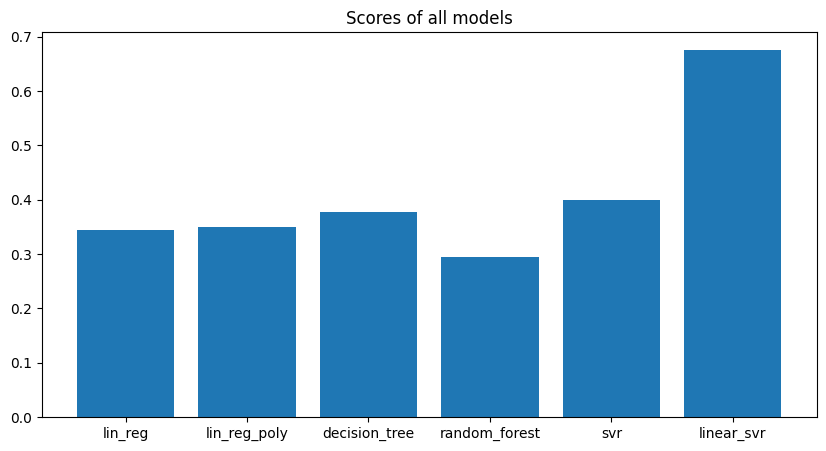

In [69]:
# Bar plot of scores and model names
plt.figure(figsize=(10, 5))
plt.bar([score[2] for score in scores.values()], [score[0] for score in scores.values()])
plt.title("Scores of all models")


In [71]:
# Save best model
best_model = joblib.load(f"output_reg/{best_scores[2]}.pkl")

with open("output_reg/best_model_reg.pkl", "wb") as file:
    joblib.dump(best_model, file)

## Classification

In [72]:
df = pd.read_csv('project_1_train.csv')
df['Diabetes'].mask(df['Diabetes'] == 'Yes', 0, inplace=True)
df['Diabetes'].mask(df['Diabetes'] == 'No', 1, inplace=True)
df["Diabetes"] = df["Diabetes"].astype(float)
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

df = df.select_dtypes(include=numerics)

max_number_of_nas = 1500
newdf = df.loc[:, (df.isnull().sum(axis=0) <= max_number_of_nas)]

newdf.dropna(inplace=True)
newdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5142 entries, 0 to 7997
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   NR           5142 non-null   int64  
 1   Age          5142 non-null   int64  
 2   HHIncomeMid  5142 non-null   float64
 3   Poverty      5142 non-null   float64
 4   HomeRooms    5142 non-null   float64
 5   Weight       5142 non-null   float64
 6   Height       5142 non-null   float64
 7   BMI          5142 non-null   float64
 8   Pulse        5142 non-null   float64
 9   BPSysAve     5142 non-null   float64
 10  BPDiaAve     5142 non-null   float64
 11  BPSys1       5142 non-null   float64
 12  BPDia1       5142 non-null   float64
 13  BPSys2       5142 non-null   float64
 14  BPDia2       5142 non-null   float64
 15  BPSys3       5142 non-null   float64
 16  BPDia3       5142 non-null   float64
 17  DirectChol   5142 non-null   float64
 18  UrineVol1    5142 non-null   float64
 19  UrineFlow1 

C:\Users\Admin\AppData\Local\Temp\ipykernel_10152\326854317.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newdf.dropna(inplace=True)


In [73]:
y_clas = newdf['Diabetes']

x_clas = newdf.drop(columns=['Diabetes'])
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(x_clas, y_clas, test_size=0.2, random_state=123)

In [74]:
X_train_c

,NR,Age,HHIncomeMid,Poverty,HomeRooms,Weight,Height,BMI,Pulse,BPSysAve,BPDiaAve,BPSys1,BPDia1,BPSys2,BPDia2,BPSys3,BPDia3,DirectChol,UrineVol1,UrineFlow1
5211,3897,50,87500.0,3.63,10.0,108.9,180.5,33.43,76.0,125.0,72.0,124.0,70.0,128.0,72.0,122.0,72.0,1.06,64.0,0.753
1475,291,65,100000.0,5.00,7.0,67.8,175.5,22.01,82.0,114.0,53.0,112.0,54.0,114.0,52.0,114.0,54.0,1.60,21.0,0.368
6290,5526,24,50000.0,2.33,4.0,92.6,176.4,29.80,70.0,102.0,56.0,102.0,58.0,102.0,56.0,102.0,56.0,1.06,33.0,0.068
7967,2429,64,100000.0,5.00,10.0,98.0,176.0,31.64,66.0,116.0,67.0,114.0,64.0,116.0,66.0,116.0,68.0,0.93,67.0,0.677
3271,9723,57,70000.0,3.13,5.0,70.8,169.3,24.70,48.0,113.0,65.0,114.0,66.0,116.0,66.0,110.0,64.0,1.14,97.0,0.890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2412,407,22,60000.0,1.39,5.0,63.8,162.0,24.31,62.0,119.0,49.0,118.0,46.0,120.0,46.0,118.0,52.0,2.12,242.0,1.485
6275,8296,73,87500.0,2.20,5.0,82.9,169.9,28.70,78.0,123.0,65.0,124.0,62.0,126.0,62.0,120.0,68.0,1.06,23.0,0.299
2020,5615,50,87500.0,5.00,7.0,94.2,175.5,30.60,78.0,110.0,79.0,112.0,84.0,108.0,80.0,112.0,78.0,0.85,56.0,0.339
5340,6515,22,30000.0,1.67,5.0,76.1,154.9,31.70,70.0,119.0,51.0,116.0,50.0,120.0,48.0,118.0,54.0,1.34,54.0,0.551


In [89]:
y_train_c.value_counts()

Diabetes
1.0    3765
0.0     348
Name: count, dtype: int64

In [90]:
# Upsample the minority class
from sklearn.utils import resample

def upsample_data(X_train_c, y_train_c):
    """
    Upsample the minority class in the dataset.
    
    Parameters:
    X_train_c (DataFrame): The features of the training data.
    y_train_c (Series): The target of the training data, indicating the presence of Diabetes.
    
    Returns:
    DataFrame, Series: The upsampled features and target data.
    """

    # Combine the features and target into a single DataFrame for resampling
    train_data = pd.concat([X_train_c, y_train_c], axis=1)

    # Separate the majority and minority classes
    majority_class = train_data[train_data.Diabetes == 1.0]
    minority_class = train_data[train_data.Diabetes == 0.0]

    # Upsample the minority class
    minority_class_upsampled = resample(minority_class,
                                        replace=True,                  # sample with replacement
                                        n_samples=len(majority_class), # to match majority class size
                                        random_state=123)              # for reproducible results

    # Combine majority class with upsampled minority class
    upsampled_data = pd.concat([majority_class, minority_class_upsampled])

    # Separate features and target
    X_train_upsampled = upsampled_data.drop('Diabetes', axis=1)
    y_train_upsampled = upsampled_data['Diabetes']

    return X_train_upsampled, y_train_upsampled

X_train_c, y_train_c = upsample_data(X_train_c, y_train_c)

In [91]:
y_train_c.value_counts()

Diabetes
1.0    3765
0.0    3765
Name: count, dtype: int64

In [92]:
scores = {}  # containing scores and pipeline info

### Logistic Regression


In [104]:
def log_reg(x, y):
    """Define model 1"""
    start = time.time()

    # Numeric feature preparation
    pipeline_num = Pipeline([
        ("selector", Selector("num features")),
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", MinMaxScaler()),
        ("pca", PCA(n_components=0.9)),
    ])

    # Categorical feature preparation
    pipeline_cat = Pipeline([
        ("selector", Selector("cat features")),
        ("one_hot_encoder", OneHotEncoder(handle_unknown="infrequent_if_exist")),
    ])

    # Combine numeric and categorical feature preparation
    pipeline_full = FeatureUnion(transformer_list=[
        ("pipeline_num", pipeline_num),
        ("pipeline_cat", pipeline_cat),
    ])


    # Define full pipeline
    base_model = Pipeline([
        ("pipeline_full", pipeline_full),
        ("classifier", LogisticRegression()),
    ])

    # possible fine-tuned parameters
    model_param = [
        # binary fit for each label
        {
            "classifier__multi_class": ["ovr"],  # binary fit for each label
            "classifier__penalty": ["l2"],
            "classifier__solver": ["lbfgs"],
            "classifier__C": [0.1],
        },
        # softmax regression
        {
            "classifier__multi_class": ["multinomial"],  # softmax regression
            "classifier__penalty": ["l2"],
            "classifier__solver": ["saga"],
            "classifier__C": [0.1],
        }
    ]

    model_gs = GridSearchCV(base_model, model_param, cv=5, n_jobs=-1, scoring="f1_weighted")
    model_gs.fit(x, y)

    model = model_gs.best_estimator_

    model_best_params = model_gs.best_params_

    # attention: it is not allowed to use a fitted model (like model) in cross_val_predict because information gets through
    # unfitted model (clone(model)) is used for cross validation

    model_new = clone(model)
    model_predictions_cv = cross_val_predict(model_new, x, y, cv=3, n_jobs=-1)

    end = time.time()
    model_time = end - start

    # store model
    joblib.dump(model, filename="output_clf/log_reg_cl.pkl")

    # use the following to store the best params of grid search
    with open("output_clf/log_reg_cl_best_params.pkl", "wb") as ff:
        pickle.dump(model_best_params, ff)

    joblib.dump(model_predictions_cv, filename="output_clf/log_reg_cl_predictions_cv.pkl")
    joblib.dump(model_time, filename="output_clf/log_reg_cl_time.pkl")


In [111]:
log_reg(X_train_c, y_train_c)

In [107]:
model_1 = joblib.load("output_clf/log_reg_cl.pkl")

with open("output_clf/log_reg_cl_best_params.pkl", 'rb') as f:
    model_1_best_params = pickle.load(f)

model_1_predictions_cv = joblib.load("output_clf/log_reg_cl_predictions_cv.pkl")
model_1_time = joblib.load("output_clf/log_reg_cl_time.pkl")

print("TIME: ", round(model_1_time, 2), " sec\n")

print("CROSS VALIDATION CONFUSION MATRIX:")
print(confusion_matrix(y_train_c, model_1_predictions_cv), "\n")

print("CROSS CLASSIFICATION REPORT:")
print(classification_report(y_train_c, model_1_predictions_cv))

model_1_score = f1_score(y_train_c, model_1_predictions_cv, average="weighted")
scores["model_1"] = [model_1_score, model_1, "log_reg_cl"]
print("VALUE FOR COMPARISON: WEIGHTED F1_SCORE:", round(model_1_score, 2), "\n")

print("OPTIMAL PARAMETERS:")
for param, value in model_1_best_params.items():
    print(param, ": ", value, sep="")
print("\n")

TIME:  1.17  sec

CROSS VALIDATION CONFUSION MATRIX:
[[2933  832]
 [1062 2703]] 

CROSS CLASSIFICATION REPORT:
              precision    recall  f1-score   support

         0.0       0.73      0.78      0.76      3765
         1.0       0.76      0.72      0.74      3765

    accuracy                           0.75      7530
   macro avg       0.75      0.75      0.75      7530
weighted avg       0.75      0.75      0.75      7530

VALUE FOR COMPARISON: WEIGHTED F1_SCORE: 0.75 

OPTIMAL PARAMETERS:
classifier__C: 0.1
classifier__multi_class: ovr
classifier__penalty: l2
classifier__solver: lbfgs




In [112]:
def log_reg_poly(x, y):
    """Define model 2"""
    start = time.time()

    # Numeric feature preparation
    pipeline_num = Pipeline([
        ("selector", Selector("num features")),
        ("imputer", SimpleImputer(strategy="median")),
        ("poly", PolynomialFeatures(degree=2)),
        ("scaler", MinMaxScaler()),
        ("pca", PCA(n_components=0.9)),
    ])

    # Categorical feature preparation
    pipeline_cat = Pipeline([
        ("selector", Selector("cat features")),
        ("one_hot_encoder", OneHotEncoder(handle_unknown="infrequent_if_exist")),
    ])

    # Combine numeric and categorical feature preparation
    pipeline_full = FeatureUnion(transformer_list=[
        ("pipeline_num", pipeline_num),
        ("pipeline_cat", pipeline_cat),
    ])


    # Define full pipeline
    base_model = Pipeline([
        ("pipeline_full", pipeline_full),
        ("classifier", LogisticRegression()),
    ])

    # possible fine-tuned parameters
    model_param = [
        # binary fit for each label
        {
            "classifier__multi_class": ["ovr"],  # binary fit for each label
            "classifier__penalty": ["l2"],
            "classifier__solver": ["lbfgs"],
            "classifier__C": [0.1],
        },
        # softmax regression
        {
            "classifier__multi_class": ["multinomial"],  # softmax regression
            "classifier__penalty": ["l2"],
            "classifier__solver": ["saga"],
            "classifier__C": [0.1],
        }
    ]

    model_gs = GridSearchCV(base_model, model_param, cv=5, n_jobs=-1, scoring="f1_weighted")
    model_gs.fit(x, y)

    model = model_gs.best_estimator_

    model_best_params = model_gs.best_params_

    # attention: it is not allowed to use a fitted model (like model) in cross_val_predict because information gets through
    # unfitted model (clone(model)) is used for cross validation

    model_new = clone(model)
    model_predictions_cv = cross_val_predict(model_new, x, y, cv=3, n_jobs=-1)

    end = time.time()
    model_time = end - start

    # store model
    joblib.dump(model, filename="output_clf/log_reg_poly_cl.pkl")

    # use the following to store the best params of grid search
    with open("output_clf/log_reg_poly_cl_best_params.pkl", "wb") as ff:
        pickle.dump(model_best_params, ff)

    joblib.dump(model_predictions_cv, filename="output_clf/log_reg_poly_cl_predictions_cv.pkl")
    joblib.dump(model_time, filename="output_clf/log_reg_poly_cl_time.pkl")


In [113]:
log_reg_poly(X_train_c, y_train_c)

In [114]:
model_2 = joblib.load("output_clf/log_reg_poly_cl.pkl")

with open("output_clf/log_reg_poly_cl_best_params.pkl", 'rb') as f:
    model_2_best_params = pickle.load(f)

model_2_predictions_cv = joblib.load("output_clf/log_reg_poly_cl_predictions_cv.pkl")
model_2_time = joblib.load("output_clf/log_reg_poly_cl_time.pkl")

print("TIME: ", round(model_2_time, 2), " sec\n")

print("CROSS VALIDATION CONFUSION MATRIX:")
print(confusion_matrix(y_train_c, model_2_predictions_cv), "\n")

print("CROSS CLASSIFICATION REPORT:")
print(classification_report(y_train_c, model_2_predictions_cv))

model_2_score = f1_score(y_train_c, model_2_predictions_cv, average="weighted")
scores["model_2"] = [model_2_score, model_2, "log_reg_poly_cl"]
print("VALUE FOR COMPARISON: WEIGHTED F1_SCORE:", round(model_2_score, 2), "\n")

print("OPTIMAL PARAMETERS:")
for param, value in model_2_best_params.items():
    print(param, ": ", value, sep="")
print("\n")

TIME:  4.29  sec

CROSS VALIDATION CONFUSION MATRIX:
[[2870  895]
 [1045 2720]] 

CROSS CLASSIFICATION REPORT:
              precision    recall  f1-score   support

         0.0       0.73      0.76      0.75      3765
         1.0       0.75      0.72      0.74      3765

    accuracy                           0.74      7530
   macro avg       0.74      0.74      0.74      7530
weighted avg       0.74      0.74      0.74      7530

VALUE FOR COMPARISON: WEIGHTED F1_SCORE: 0.74 

OPTIMAL PARAMETERS:
classifier__C: 0.1
classifier__multi_class: ovr
classifier__penalty: l2
classifier__solver: lbfgs




### Support Vector Machine

In [122]:
def svc_clf(X, y):
    """Support Vector Machine Classification."""
    start = time.time()

    # Numeric feature preparation
    pipeline_num = Pipeline([
        ("selector", Selector("num features")),
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", MinMaxScaler()),
        ("pca", PCA(n_components=0.9)),
    ])

    # Categorical feature preparation
    pipeline_cat = Pipeline([
        ("selector", Selector("cat features")),
        ("one_hot_encoder", OneHotEncoder(handle_unknown="infrequent_if_exist")),
    ])

    # Combine numeric and categorical feature preparation
    pipeline_full = FeatureUnion(transformer_list=[
        ("pipeline_num", pipeline_num),
        ("pipeline_cat", pipeline_cat),
    ])

    # Define full pipeline
    base_model = Pipeline([
        ("pipeline_full", pipeline_full),
        ("classifier", SVC(random_state=123)),
    ])

    # Possible fine-tuned parameters
    model_param = [
        {
            "classifier__C": [0.1, 1, 10],  # Regularization parameter
            "classifier__kernel": ["rbf", "poly", "sigmoid"],  # Specifies the kernel type
            "classifier__gamma": ["scale", "auto"],  # Kernel coefficient
        }
    ]

    model_gs = GridSearchCV(base_model, model_param, cv=5, n_jobs=-1, scoring="f1_weighted")
    model_gs.fit(X, y)

    model = model_gs.best_estimator_
    model_best_params = model_gs.best_params_

    # Attention: Use a clone of the model for cross-validation predictions
    model_new = clone(model)
    model_predictions_cv = cross_val_predict(model_new, X, y, cv=3, n_jobs=-1)

    end = time.time()
    model_time = end - start

    # Store model and results
    joblib.dump(model, filename="output_clf/svc_clf.pkl")
    with open("output_clf/svc_clf_best_params.pkl", "wb") as ff:
        pickle.dump(model_best_params, ff)
    joblib.dump(model_predictions_cv, filename="output_clf/svc_clf_predictions_cv.pkl")
    joblib.dump(model_time, filename="output_clf/svc_clf_time.pkl")


In [123]:
svc_clf(X_train_c, y_train_c)

In [125]:
model_3 = joblib.load("output_clf/svc_clf.pkl")

with open("output_clf/svc_clf_best_params.pkl", 'rb') as f:
    model_3_best_params = pickle.load(f)

model_3_predictions_cv = joblib.load("output_clf/svc_clf_predictions_cv.pkl")
model_3_time = joblib.load("output_clf/svc_clf_time.pkl")

print("TIME: ", round(model_3_time, 2), " sec\n")

print("CROSS VALIDATION CONFUSION MATRIX:")
print(confusion_matrix(y_train_c, model_3_predictions_cv), "\n")

print("CROSS CLASSIFICATION REPORT:")
print(classification_report(y_train_c, model_3_predictions_cv))

model_3_score = f1_score(y_train_c, model_3_predictions_cv, average="weighted")
scores["model_3"] = [model_3_score, model_3, "svc_clf"]
print("VALUE FOR COMPARISON: WEIGHTED F1_SCORE:", round(model_3_score, 2), "\n")

print("OPTIMAL PARAMETERS:")
for param, value in model_3_best_params.items():
    print(param, ": ", value, sep="")
print("\n")

TIME:  87.26  sec

CROSS VALIDATION CONFUSION MATRIX:
[[3523  242]
 [ 707 3058]] 

CROSS CLASSIFICATION REPORT:
              precision    recall  f1-score   support

         0.0       0.83      0.94      0.88      3765
         1.0       0.93      0.81      0.87      3765

    accuracy                           0.87      7530
   macro avg       0.88      0.87      0.87      7530
weighted avg       0.88      0.87      0.87      7530

VALUE FOR COMPARISON: WEIGHTED F1_SCORE: 0.87 

OPTIMAL PARAMETERS:
classifier__C: 10
classifier__gamma: scale
classifier__kernel: rbf




In [130]:
def linear_svc_clf(X, y):
    """Linear Support Vector Machine Classification."""
    start = time.time()

    # Numeric feature preparation
    pipeline_num = Pipeline([
        ("selector", Selector("num features")),
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", MinMaxScaler()),
        ("pca", PCA(n_components=0.9)),
    ])

    # Categorical feature preparation
    pipeline_cat = Pipeline([
        ("selector", Selector("cat features")),
        ("one_hot_encoder", OneHotEncoder(handle_unknown="infrequent_if_exist")),
    ])

    # Combine numeric and categorical feature preparation
    pipeline_full = FeatureUnion(transformer_list=[
        ("pipeline_num", pipeline_num),
        ("pipeline_cat", pipeline_cat),
    ])

    # Define full pipeline
    base_model = Pipeline([
        ("pipeline_full", pipeline_full),
        ("classifier", LinearSVC(random_state=123)),
    ])

    # Possible fine-tuned parameters
    model_param = [
        {
            "classifier__penalty": ["l2"],
            "classifier__loss": ["squared_hinge"],  # Typically used for linear SVM
            "classifier__C": [0.1, 1, 10],  # Regularization parameter
            "classifier__dual": [True, False],  # Dual or primal formulation
        }
    ]

    model_gs = GridSearchCV(base_model, model_param, cv=5, n_jobs=-1, scoring="f1_weighted")
    model_gs.fit(X, y)

    model = model_gs.best_estimator_
    model_best_params = model_gs.best_params_

    # Attention: Use a clone of the model for cross-validation predictions
    model_new = clone(model)
    model_predictions_cv = cross_val_predict(model_new, X, y, cv=3, n_jobs=-1)

    end = time.time()
    model_time = end - start

    # Store model and results
    joblib.dump(model, filename="output_clf/linear_svc_clf.pkl")
    with open("output_clf/linear_svc_clf_best_params.pkl", "wb") as ff:
        pickle.dump(model_best_params, ff)
    joblib.dump(model_predictions_cv, filename="output_clf/linear_svc_clf_predictions_cv.pkl")
    joblib.dump(model_time, filename="output_clf/linear_svc_clf_time.pkl")


In [131]:
linear_svc_clf(X_train_c, y_train_c)

In [132]:
model_4 = joblib.load("output_clf/linear_svc_clf.pkl")

with open("output_clf/linear_svc_clf_best_params.pkl", 'rb') as f:
    model_4_best_params = pickle.load(f)

model_4_predictions_cv = joblib.load("output_clf/linear_svc_clf_predictions_cv.pkl")
model_4_time = joblib.load("output_clf/linear_svc_clf_time.pkl")

print("TIME: ", round(model_4_time, 2), " sec\n")

print("CROSS VALIDATION CONFUSION MATRIX:")
print(confusion_matrix(y_train_c, model_4_predictions_cv), "\n")

print("CROSS CLASSIFICATION REPORT:")
print(classification_report(y_train_c, model_4_predictions_cv))

model_4_score = f1_score(y_train_c, model_4_predictions_cv, average="weighted")
scores["model_4"] = [model_4_score, model_4, "linear_svc_clf"]
print("VALUE FOR COMPARISON: WEIGHTED F1_SCORE:", round(model_4_score, 2), "\n")

print("OPTIMAL PARAMETERS:")
for param, value in model_4_best_params.items():
    print(param, ": ", value, sep="")
print("\n")

TIME:  2.42  sec

CROSS VALIDATION CONFUSION MATRIX:
[[2952  813]
 [1091 2674]] 

CROSS CLASSIFICATION REPORT:
              precision    recall  f1-score   support

         0.0       0.73      0.78      0.76      3765
         1.0       0.77      0.71      0.74      3765

    accuracy                           0.75      7530
   macro avg       0.75      0.75      0.75      7530
weighted avg       0.75      0.75      0.75      7530

VALUE FOR COMPARISON: WEIGHTED F1_SCORE: 0.75 

OPTIMAL PARAMETERS:
classifier__C: 0.1
classifier__dual: True
classifier__loss: squared_hinge
classifier__penalty: l2




### Random Forest